In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
import os
import random
from IPython.display import display

sns.set_palette(sns.color_palette('deep'))
sns.set_style('whitegrid')

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_colwidth', 80)

# Read data

## CellAge

In [2]:
cellage_df = pd.read_csv('data/cellage_export.tsv', sep='\t')

In [3]:
cellage_df.head()

,gene_symbol,entrez_id,method,cell_type,cell_line,cancer_cell,senescence_type,senescence_effect,description,organism
0,AAK1,22848,Overexpression,"Lung fibroblast, Embryonic kidney","IMR-90, MRC-5, HEK293T",No,Replicative,Promotes,A library of 200 constitutively activated kinases was screened in order to i...,A library of 200 constitutively activated kinases was screened in order to i...
1,ABI3,51225,Overexpression,"Thyroid cancer, Colon cancer","WRO, ARO",Yes,Replicative,Promotes,"Ectopic expression of ABI3 lowered transforming activity, reduced in vitro t...","Ectopic expression of ABI3 lowered transforming activity, reduced in vitro t..."
2,ACLY,47,Knockout,Dermal fibroblast,Primary cell,No,Replicative,Inhibits,ACLY knockdown in primary human cells triggered cellular senescence and acti...,ACLY knockdown in primary human cells triggered cellular senescence and acti...
3,ADCK5,203054,Overexpression,"Embryonic kidney, Lung fibroblast","IMR-90, MRC-5, HEK293T",No,Replicative,Promotes,A library of 200 constitutively activated kinases was screened in order to i...,A library of 200 constitutively activated kinases was screened in order to i...
4,AGT,183,"Overexpression, Knockout",Vascular smooth muscle,Primary cell,No,Replicative,Promotes,Treatment with Ang II (AGT) of vascular smooth muscle cells significantly in...,Treatment with Ang II (AGT) of vascular smooth muscle cells significantly in...


## Basic gene info

In [112]:
genes_df = pd.read_csv('data/gene_info.txt', sep='\t', dtype={'entrez_id': 'int'})

In [113]:
genes_df.columns = ['hgnc_id', 'symbol', 'name', 'status', 'prev_symbols', 'synonyms', 'chromosome', 'accession_numbers', 'refseq_ids', 'entrez_id']

In [117]:
genes_df = genes_df.query('entrez_id == entrez_id')

In [119]:
genes_df['entrez_id'] = genes_df.entrez_id.astype('int')

In [120]:
genes_df.head()

,hgnc_id,symbol,name,status,prev_symbols,synonyms,chromosome,accession_numbers,refseq_ids,entrez_id
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974
3,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2
4,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),Approved,NaN,NaN,12p13.31,NaN,NR_026971,144571


In [125]:
def entrez_ids_to_symbols(ids):
    df = genes_df.set_index('entrez_id')
    return df.loc[ids].symbol.values

In [126]:
entrez_ids_to_symbols([1, 2])

array(['A1BG', 'A2M'], dtype=object)

# Summarize

In [4]:
cellage_df.senescence_type.value_counts()

Replicative                      217
Stress-induced                    24
Oncogene-induced                  23
Stress-induced, Replicative        6
Replicative, Stress-induced        4
Replicative, Oncogene-induced      3
Oncogene-induced, Replicative      2
Name: senescence_type, dtype: int64

In [5]:
cellage_df.senescence_effect.value_counts()

Promotes    153
Inhibits    121
Unclear       5
Name: senescence_effect, dtype: int64

# Read Gene Ontology Data

In [6]:
# Get http://geneontology.org/ontology/go-basic.obo
#from goatools.base import download_go_basic_obo
#obo_fname = download_go_basic_obo()

In [7]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
#from goatools.base import download_ncbi_associations
#gene2go = download_ncbi_associations()

In [8]:
from goatools.obo_parser import GODag

obodag = GODag("data/go-basic.obo")

load obo file data/go-basic.obo
data/go-basic.obo: fmt(1.2) rel(2017-09-20) 46,992 GO Terms


In [9]:
from goatools.associations import read_ncbi_gene2go

In [10]:
#taxonomy ID 9606 is Human

In [11]:
geneid2gos_human = read_ncbi_gene2go("data/gene2go", taxids=[9606])

print("{N:,} annotated human genes".format(N=len(geneid2gos_human)))

  READ: data/gene2go
19,238 annotated human genes


In [103]:
next(iter(obodag))

'GO:0000001'

In [12]:
GO_name_map = {go.id:go.name for go in obodag.values()}
GO_ns_map = {go.id:go.namespace for go in obodag.values()}

## Run Enrichment Study

In [13]:
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GeneID2nt as GeneID2nt_hum

In [14]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
        GeneID2nt_hum.keys(), # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact
18,400 out of 20,913 population items found in association


In [15]:
list(GeneID2nt_hum.keys())[:10]

[1, 2, 131076, 9, 10, 12, 13, 14, 15, 16]

In [16]:
goea_results_all = goeaobj.run_study(cellage_df.entrez_id.values)

Calculating uncorrected p-values using fisher_scipy_stats
   277 out of    279 study items found in association
Running multitest correction: statsmodels fdr_bh
  3,383 GO terms are associated with 277 of 279 study items
  17,434 GO terms are associated with 18,400 of 20,913 population items


In [17]:
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

In [18]:
len(goea_results_sig)

336

## Write out results

In [19]:
goeaobj.wr_xlsx("data/cellage_goea.xlsx", goea_results_sig)

    336 items WROTE: data/cellage_goea.xlsx


In [20]:
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

plot_results("cellage_{NS}.png", goea_results_sig)

  247 usr 977 GOs  WROTE: cellage_BP.png
   26 usr  75 GOs  WROTE: cellage_CC.png
   63 usr 147 GOs  WROTE: cellage_MF.png


## Show enrichment results

In [21]:
results_df = pd.DataFrame.from_records(
    [(r.GO, r.get_pvalue(),
     1.0 * (r.ratio_in_study[0] / r.ratio_in_study[1]) / (r.ratio_in_pop[0] / r.ratio_in_pop[1]),
     r.ratio_in_study[0],
     r.NS, r.name)
     for r in goea_results_sig
    ],
    columns=['id', 'pvalue', 'enrichment', 'cellage_count', 'ns', 'name']
)

In [22]:
results_df.query('enrichment > 3 and pvalue < 0.001').sort_values('pvalue', ascending=True)[:50]

,id,pvalue,enrichment,cellage_count,ns,name
248,GO:0005654,1.560954e-35,3.270941,131,CC,nucleoplasm
274,GO:0004674,4.128163e-25,9.156678,43,MF,protein serine/threonine kinase activity
0,GO:0000122,4.568953e-24,5.697910,58,BP,negative regulation of transcription from RNA polymerase II promoter
1,GO:0045944,1.295481e-23,4.779866,66,BP,positive regulation of transcription from RNA polymerase II promoter
2,GO:0006468,1.485259e-21,7.375631,43,BP,protein phosphorylation
275,GO:0005524,4.814790e-21,3.807012,74,MF,ATP binding
3,GO:0008285,1.471026e-19,7.457456,39,BP,negative regulation of cell proliferation
4,GO:0045893,8.638668e-18,6.031022,42,BP,"positive regulation of transcription, DNA-templated"
5,GO:0045892,1.730570e-16,6.077594,39,BP,"negative regulation of transcription, DNA-templated"
276,GO:0003682,5.293327e-13,6.246416,31,MF,chromatin binding


# Make Senescence Classifier

In [23]:
import sklearn

In [24]:
gene_ids = list(geneid2gos_human.keys())

In [25]:
gene_terms = list(geneid2gos_human.values())

## Encode GO terms with one-hot vectorization

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
identity = lambda x: x

In [28]:
vectorizer = CountVectorizer(lowercase=False, preprocessor=identity, binary=True, analyzer=identity)

Create the feature vector:

In [29]:
X = vectorizer.fit_transform(gene_terms)

In [30]:
X

<19238x17506 sparse matrix of type '<class 'numpy.int64'>'
	with 264388 stored elements in Compressed Sparse Row format>

Double check the vectorization:

In [31]:
X.sum(axis=1).A1[:10]

array([10, 24,  3,  4, 19, 11, 13, 20, 18, 37])

In [32]:
X

<19238x17506 sparse matrix of type '<class 'numpy.int64'>'
	with 264388 stored elements in Compressed Sparse Row format>

In [33]:
[len(terms) for terms in gene_terms[:10]]

[10, 24, 3, 4, 19, 11, 13, 20, 18, 37]

## Label the genes as senescence-related or not

In [34]:
gene_ids[:10]

[1, 2, 9, 10, 12, 13, 14, 15, 16, 18]

In [35]:
cellage_id_set = set(cellage_df.entrez_id.values)
len(cellage_id_set)

279

In [36]:
labels = np.array([gene_id in cellage_id_set for gene_id in gene_ids])

In [37]:
labels.sum()

277

Two genes aren't in the GO? That's odd...

## Train & Test a few classifiers

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

In [54]:
def show_classifier_performance(labels, label_preds, thresh=0.5, names=None):
    y = labels
    yhat = label_preds[:, 1]
    if names is None:
        names = ['Other', 'Senescense-related']
    conf_mat = pd.DataFrame(confusion_matrix(y, yhat > thresh), index=names, columns=names)
    print('Confusion Matrix')
    display(conf_mat)
    print('\nClassification Report') 
    display(pd.DataFrame.from_records(
        precision_recall_fscore_support(y, yhat > thresh),
        index=['Precision', 'Recall', 'F-Score', 'Support'],
        columns=names
    ).T)
    fpr, tpr, _ = roc_curve(y, yhat)
    plot_roc(fpr, tpr)

In [55]:
def plot_roc(fpr, tpr):
    plt.figure(figsize=(6,6))
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.plot(
        fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

In [56]:
def get_top_features(clf, vectorizer):
    feat_names = vectorizer.get_feature_names()
    if hasattr(clf, 'best_estimator_'):
        clf = clf.best_estimator_
    else:
        clf = clf
    if hasattr(clf, 'coef_'):
        if len(clf.coef_.shape) > 1:
            importances = clf.coef_[0].T
        importances = clf.coef_.T
    elif hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    assert len(importances) == len(feat_names), 'length mismatch: {} != {}'.format(
        len(importances), len(feat_names)
    )
    df = pd.DataFrame(importances, index=feat_names)
    df.columns = ['importance']
    df['abs_importance'] = df.importance.abs()
    return df.sort_values(
        'abs_importance', ascending=False
    ).drop('abs_importance', axis=1)

In [57]:
ns_abbrev_map = {'molecular_function': 'MF', 'biological_process': 'BP', 'cellular_component': 'CC'}
def go_annotate(df):
    df['namespace'] = df.index.map(lambda i: ns_abbrev_map[GO_ns_map[i]])
    df['name'] = df.index.map(lambda i: GO_name_map[i])
    return df

In [173]:
network_candidates = [
    'SMAD3', 'EP300', 'CREBBP', 'MDM2', 'HDAC2', 'BTRC', 'DNMT1 ',
    'PIN1', 'SKP2', 'KDM4C', 'PTPN6', 'SASH3', 'ARHGAP30', 'SMC4 '
]

def get_candidates(preds, labels, gene_ids, n=20, gene_list=None):
    assert len(preds) == len(labels) == len(gene_ids)
    cand_df = pd.DataFrame(
        np.stack([labels, preds], axis=1),
        columns=['label', 'predicted_prob'], index=pd.Index(gene_ids, name='entrez_id'))
    cand_df['symbol'] = entrez_ids_to_symbols(cand_df.index)
    cand_df = cand_df.sort_values('predicted_prob', ascending=False).query('label < 1').drop('label', axis=1)
    cand_df['percentile'] = 100.0 * np.arange(0, len(cand_df)) / (len(cand_df) - 1)
    cand_df = cand_df.reset_index().set_index('symbol')
    
    if gene_list is not None:
        return cand_df.loc[gene_list]
    else:
        return cand_df.head(n)

### Naive Bayes
With so many binary features and such high sparsity, Naive Bayes, while simple, is a good bet

In [543]:
from sklearn.naive_bayes import BernoulliNB

In [544]:
clf = BernoulliNB(fit_prior=False)

In [545]:
label_preds = cross_val_predict(clf, X, labels, cv=3, method='predict_proba')

Confusion Matrix


,Other,Senescense-related
Other,18502,459
Senescense-related,228,49



Classification Report


,Precision,Recall,F-Score,Support
Other,0.987827,0.975792,0.981773,18961.0
Senescense-related,0.096457,0.176895,0.124841,277.0


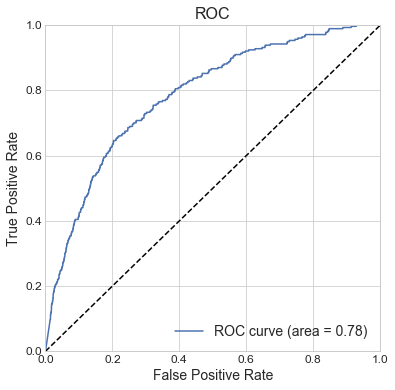

In [546]:
show_classifier_performance(labels, label_preds)

In [547]:
clf.fit(X, labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

### ElasticNet

Use strong regularization to deal with so many parameters

In [189]:
import sklearn.linear_model

In [190]:
clf = sklearn.linear_model.SGDClassifier(
    loss='log', penalty='elasticnet', alpha=0.01, l1_ratio=0.15, class_weight='balanced', max_iter=100
)

In [191]:
clf.fit(X, labels)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [66]:
label_preds = cross_val_predict(clf, X, labels, cv=10, method='predict_proba', n_jobs=-1)

Confusion Matrix


,Other,Senescense-related
Other,17679,1282
Senescense-related,161,116



Classification Report


,Precision,Recall,F-Score,Support
Other,0.990975,0.932388,0.960789,18961.0
Senescense-related,0.082976,0.418773,0.138507,277.0


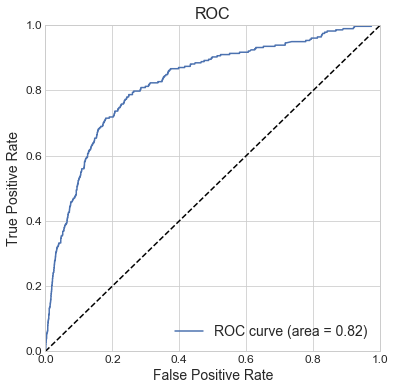

In [67]:
show_classifier_performance(labels, label_preds, thresh=0.7)

In [69]:
clf.fit(X, labels)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [646]:
top_feats = go_annotate(get_top_features(clf, vectorizer))

In [647]:
top_feats[:50]

,importance,namespace,name
GO:0016021,-0.824735,CC,integral component of membrane
GO:0008285,0.731192,BP,negative regulation of cell proliferation
GO:0000122,0.587924,BP,negative regulation of transcription from RNA polymerase II promoter
GO:0004674,0.491604,MF,protein serine/threonine kinase activity
GO:0006468,0.483493,BP,protein phosphorylation
GO:0005654,0.465936,CC,nucleoplasm
GO:0005524,0.417341,MF,ATP binding
GO:0045944,0.412141,BP,positive regulation of transcription from RNA polymerase II promoter
GO:0005634,0.340402,CC,nucleus
GO:0005622,0.334649,CC,intracellular


In [193]:
senes_preds = clf.predict_proba(X)[:, 1]

### Random Forest

In [556]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [557]:
base_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')

In [558]:
param_dict1 = {
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': stats.randint(2, 10),
    'max_depth': stats.randint(5, 25),
    'min_samples_leaf': [1, 20, 0.01, 0.001],
}

# this set of parameters performs worse
param_dict2 = {"max_depth": [3, None],
              "max_features": stats.randint(1, 11),
              "min_samples_split": stats.randint(2, 11),
              "min_samples_leaf": stats.randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [559]:
clf = RandomizedSearchCV(base_clf, param_distributions=param_dict1)

In [560]:
label_preds = cross_val_predict(clf, X, labels, cv=3, method='predict_proba', n_jobs=-1)

Confusion Matrix


,Other,Senescense-related
Other,18797,164
Senescense-related,257,20



Classification Report


,Precision,Recall,F-Score,Support
Other,0.986512,0.991351,0.988925,18961.0
Senescense-related,0.108696,0.072202,0.086768,277.0


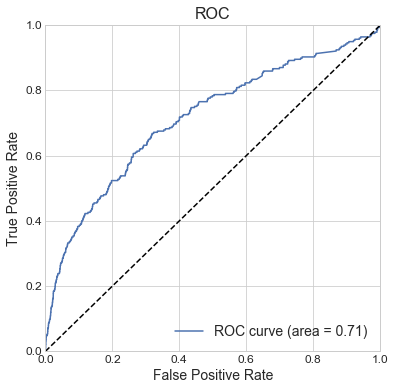

In [561]:
show_classifier_performance(labels, label_preds)

In [562]:
clf.fit(X, labels)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1270357b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x127035a58>, 'min_samples_leaf': [1, 20, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [563]:
top_feats = go_annotate(get_top_features(clf, vectorizer))

In [564]:
top_feats[:50]

,importance,namespace,name
GO:0005515,0.021319,molecular_function,protein binding
GO:0005634,0.020277,cellular_component,nucleus
GO:0005654,0.011977,cellular_component,nucleoplasm
GO:0004674,0.011087,molecular_function,protein serine/threonine kinase activity
GO:0008285,0.008774,biological_process,negative regulation of cell proliferation
GO:0006977,0.006933,biological_process,"DNA damage response, signal transduction by p53 class mediator resulting in ..."
GO:0000122,0.005896,biological_process,negative regulation of transcription from RNA polymerase II promoter
GO:0002039,0.005693,molecular_function,p53 binding
GO:0043066,0.005457,biological_process,negative regulation of apoptotic process
GO:0051301,0.005450,biological_process,cell division


# Make Pro- vs. Anti- Senescense classifier

## Make dataset

In [39]:
gene_ids_df = pd.DataFrame(gene_ids, columns=['entrez_id'])

In [40]:
gene_ids_df = gene_ids_df.merge(cellage_df, on='entrez_id', how='left')

In [41]:
cellage_indices = gene_ids_df[gene_ids_df.senescence_effect.isin(['Promotes', 'Inhibits'])].index

In [42]:
cellage_indices

Int64Index([   34,   128,   142,   163,   170,   263,   320,   329,   385,
              409,
            ...
            13650, 13922, 14899, 15618, 15639, 16274, 16408, 16778, 16796,
            16912],
           dtype='int64', length=272)

In [43]:
labels_sene = gene_ids_df.loc[cellage_indices, 'senescence_effect'] == 'Promotes'

In [44]:
rows = []
for idx in cellage_indices:
    rows.append(X.getrow(idx).todense())

In [45]:
X_sene = np.vstack(rows)

In [46]:
X_sene.shape

(272, 17506)

### ElasticNet

Use strong regularization to deal with so many parameters

In [47]:
import sklearn.linear_model

In [48]:
#base_clf = sklearn.linear_model.SGDClassifier(
#    loss='log', penalty='elasticnet', l1_ratio=0.15, class_weight='balanced', max_iter=100
#)

In [49]:
#clf = RandomizedSearchCV(base_clf, param_distributions={'alpha':[2**i for i in range(-16, 1)]})

In [178]:
clf = sklearn.linear_model.SGDClassifier(
    loss='log', penalty='elasticnet', l1_ratio=0.15,
    class_weight='balanced', max_iter=100, alpha=0.01
) 

In [51]:
clf.fit(X_sene, labels_sene)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [58]:
label_preds = cross_val_predict(clf, X_sene, labels_sene, cv=10, method='predict_proba', n_jobs=-1)

Confusion Matrix


,Anti,Pro
Anti,69,51
Pro,48,104



Classification Report


,Precision,Recall,F-Score,Support
Anti,0.589744,0.575000,0.582278,120.0
Pro,0.670968,0.684211,0.677524,152.0


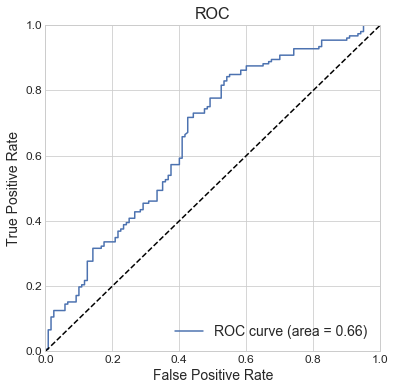

In [59]:
show_classifier_performance(labels_sene, label_preds, names=['Anti', 'Pro'])

In [179]:
clf.fit(X_sene, labels_sene)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [61]:
top_feats = go_annotate(get_top_features(clf, vectorizer))

In [62]:
top_feats[:50]

,importance,namespace,name
GO:0016020,-0.851689,CC,membrane
GO:0005654,-0.770552,CC,nucleoplasm
GO:0005524,0.659829,MF,ATP binding
GO:0051301,-0.658073,BP,cell division
GO:0008285,0.526409,BP,negative regulation of cell proliferation
GO:0000139,0.457541,CC,Golgi membrane
GO:0006355,0.451376,BP,"regulation of transcription, DNA-templated"
GO:0016310,0.448670,BP,phosphorylation
GO:0003700,0.447218,MF,"transcription factor activity, sequence-specific DNA binding"
GO:0007265,0.435431,BP,Ras protein signal transduction


In [185]:
pro_senes_preds = clf.predict_proba(X)[:, 1]

In [186]:
len(pro_senes_preds)

19238

# Predict senescence candidates

In [196]:
senes_cands = get_candidates(senes_preds, labels, gene_ids)

In [199]:
senes_cands

,entrez_id,predicted_prob,percentile
symbol,,,
CTNNB1,1499,0.980624,0.000000
TGFB1,7040,0.979938,0.005274
RARA,5914,0.977637,0.010549
STK4,6789,0.970696,0.015823
STK11,6794,0.969354,0.021097
TFAP2A,7020,0.967554,0.026371
STAT3,6774,0.965576,0.031646
HIPK2,28996,0.963538,0.036920
GLI3,2737,0.962616,0.042194


In [197]:
network_cands = get_candidates(preds, labels, gene_ids, gene_list=network_candidates)

In [200]:
network_cands

,entrez_id,predicted_prob,percentile
symbol,,,
SMAD3,4088.0,0.927440,0.342827
EP300,2033.0,0.858555,1.255274
CREBBP,1387.0,0.885856,0.785865
MDM2,4193.0,0.869509,1.060127
HDAC2,3066.0,0.896405,0.654008
BTRC,8945.0,0.748581,4.071730
DNMT1,NaN,NaN,NaN
PIN1,5300.0,0.713580,5.559072
SKP2,6502.0,0.743932,4.266878


## candidate pro vs. anti senescence predictions

In [198]:
get_candidates(pro_senes_preds, labels, gene_ids, gene_list=senes_cands.index)

,entrez_id,predicted_prob,percentile
symbol,,,
CTNNB1,1499,0.487738,68.380802
TGFB1,7040,0.625801,21.793249
RARA,5914,0.649523,17.716245
STK4,6789,0.801575,2.895570
STK11,6794,0.675105,13.101266
TFAP2A,7020,0.125492,99.377637
STAT3,6774,0.870377,0.469409
HIPK2,28996,0.723079,8.243671
GLI3,2737,0.432080,78.486287


In [201]:
get_candidates(pro_senes_preds, labels, gene_ids, gene_list=network_candidates)

,entrez_id,predicted_prob,percentile
symbol,,,
SMAD3,4088.0,0.537962,52.837553
EP300,2033.0,0.322959,90.052743
CREBBP,1387.0,0.639069,19.477848
MDM2,4193.0,0.168215,98.454641
HDAC2,3066.0,0.458390,73.982068
BTRC,8945.0,0.257423,94.978903
DNMT1,NaN,NaN,NaN
PIN1,5300.0,0.355147,87.315401
SKP2,6502.0,0.220372,97.009494
